# Utpalraj Kemprai

Installing gdown

In [1]:
!pip install gdown

### Importing the required libraries

In [2]:
import os
import json
import re
from collections import Counter
from tqdm import tqdm
import string
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import gdown
import zipfile
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

#### Link of the shared dataset
https://drive.google.com/file/d/1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm/view?usp=sharing

### Downloading the partial dataset

In [3]:
file_id = '1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm'

In [4]:
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'partial_dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm
From (redirected): https://drive.google.com/uc?id=1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm&confirm=t&uuid=22ed8cad-c9fa-4fd3-873d-ed33ceb6e884
To: /kaggle/working/partial_dataset.zip
100%|██████████| 1.00G/1.00G [00:04<00:00, 224MB/s] 


'partial_dataset.zip'

### Extracting the data from the downloaded zipped file

In [5]:
zip_path = 'partial_dataset.zip'
extract_dir = 'JSON_files'

In [6]:
def extract_zip(zip_path, extract_dir):
  '''
  Extracts the zip file to the specified directory.

  Args:
    zip_path: The path to the zip file.
    extract_dir: The directory to extract the zip file to.
  '''
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

num_cores = multiprocessing.cpu_count()

with ProcessPoolExecutor(max_workers=num_cores) as executor:
  executor.submit(extract_zip, zip_path, extract_dir)


### Function to read the json files and store them as a text corpus

In [7]:
def read_file(filename):
    '''
    Reads a JSON file and returns its content as a string.

    Args:
      filename: The path to the JSON file.

    Returns:
      The content of the JSON file as a string.
    '''
    with open(filename, 'r') as f:
        paper_content = json.load(f)
    body_text = ''
    abstract = ''
    title = ''
    if 'title' in paper_content:
      title = str(paper_content['title'])
    if 'abstract' in paper_content:
      for content in paper_content['abstract']:
        if 'text' in content:
          abstract += content['text']
    if 'body_text' in paper_content:
      for content in paper_content['body_text']:
        if 'text' in content:
          body_text += content['text']

    return title + ' ' + abstract + ' ' + body_text

def read_files(directory):
    '''
    Reads all JSON files in a directory and returns their contents as a list of strings.

    Args:
      directory: The path to the directory containing the JSON files.

    Yields:
      The content of each JSON file as a string.
    '''
    filenames = (os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.json'))
    with ProcessPoolExecutor() as executor:
        # Using map to process files in parallel
        for result in tqdm(executor.map(read_file, filenames)):
            yield result


In [8]:
text_corpus = list(read_files('JSON_files/pdf_json/'))

56528it [00:52, 1073.14it/s]


### Functions for preprocessing the corpus

In [9]:
def casefolding(text):
  '''
  Converts the given text to lowercase.

  Args:
    text: The input text.

  Returns:
    The text in lowercase.
  '''
  return text.lower()

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
def tokenize_text(text):
  '''
  Tokenizes the given text.

  Args:
    text: The input text.

  Returns:
    A list of tokens.
  '''
  return word_tokenize(text)

In [12]:
def remove_special_chars_and_numbers_from_tokenized_text(tokens):
  """
  Removes numbers and special characters from a list of tokens.

  Args:
    tokens: A list of tokens.

  Returns:
    A new list of tokens with numbers and special characters removed.
  """
  pattern = r'[a-z]+'
  filtered_tokens = [token for token in tokens if token.isalpha()]
  return filtered_tokens


In [13]:
def remove_punctuations_from_tokenized_text(tokens):
  """
  Removes punctuations from a list of tokens.

  Args:
    tokens: A list of tokens.

  Returns:
    A new list of tokens with punctuations removed.
  """
  filtered_tokens = [token for token in tokens if not any(p in token for p in string.punctuation)]
  return filtered_tokens

In [14]:
def remove_extra_whitespaces_from_tokenized_text(tokens):
  """
  Removes extra whitespaces from a list of tokens.

  Args:
    tokens: A list of tokens.

  Returns:
    A new list of tokens with extra whitespaces removed.
  """
  return [token.replace(" ", "") for token in tokens]

In [15]:
def preprocess_text(text):
  '''
  Preprocesses the text by removing special characters and numbers, converting to lowercase,
  and tokenizing the text.

  Args:
    text: The text to be preprocessed.

  Returns:
    A list of preprocessed tokens.
  '''
  text = text.lower()
  tokens = tokenize_text(text)
  tokens = remove_punctuations_from_tokenized_text(tokens)
  tokens = remove_extra_whitespaces_from_tokenized_text(tokens)
  tokens = remove_special_chars_and_numbers_from_tokenized_text(tokens)
  return tokens

def preprocess_corpus(corpus):
  '''
  Preprocesses the corpus by applying the preprocess_text function to each document in parallel.

  Args:
    corpus: A list of documents.

  Returns:
    A list of preprocessed documents.
  '''
  with ProcessPoolExecutor() as executor:
    return list(tqdm(executor.map(preprocess_text, corpus), total=len(corpus)))



### Preprocessing the corpus

Order of pre-processing steps
1.   Casefolding
2.   Tokenization
3.   Removing punctuations
4.   Removing extra white spaces 
5.   Removing words with numbers and special characters





In [16]:
tokenized_corpus = preprocess_corpus(text_corpus)

100%|██████████| 56528/56528 [28:45<00:00, 32.75it/s]  


### Functions for calculating the weighted term frequency and finding the ranks and frequencies of the word

In [17]:
def calculate_weighted_tf(tokenized_corpus):
  ''''
  Calculates the weighted term frequency for each word in the given tokenized corpus.

  Args:
    tokenized_corpus: A list of tokenized texts.

  Returns:
    A dictionary mapping words to their weighted term frequency.
  '''
  word_counts = Counter()
  for doc in tokenized_corpus:
    word_counts.update(doc)
  total_words = sum(word_counts.values())
  weighted_tf = {word: count/total_words for word, count in word_counts.items()}
  return weighted_tf

def zipfs_law(weighted_tf):
  '''
  Calculates the ranks and frequencies of the words based on their weighted term frequency.

  Args:
    weighted_tf: A dictionary mapping words to their weighted term frequency.

  Returns:
    A tuple containing the ranks and frequencies of the words.
  '''
  sorted_tf = dict(sorted(weighted_tf.items(), key=lambda item: item[1], reverse=True))
  ranks = range(1, len(sorted_tf) + 1)
  frequencies = list(sorted_tf.values())
  return ranks, frequencies


### Zipf's law: $word\_{frequency}$ ∝ $\frac{1}{rank^{\alpha}}$, where $\alpha ≈ 1$
Plotting $\log(word\_{frequency})$ vs $\log(rank)$ to find $\alpha$

Estimated value of alpha: 1.5984498767385238


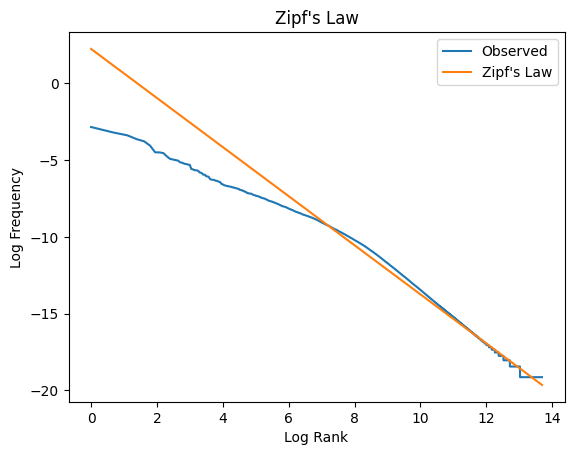

In [18]:
weighted_tf = calculate_weighted_tf(tokenized_corpus)
ranks, frequencies = zipfs_law(weighted_tf)


log_ranks = np.log(ranks)
log_frequencies = np.log(frequencies)

# Fit a linear model to estimate alpha
neg_alpha, intercept = np.polyfit(log_ranks, log_frequencies, 1)
print(f"Estimated value of alpha: {-neg_alpha}")

plt.plot(log_ranks, log_frequencies, label = 'Observed')
plt.plot(log_ranks, neg_alpha * np.array(log_ranks) + intercept, label="Zipf's Law")
plt.xlabel("Log Rank")
plt.ylabel("Log Frequency")
plt.title("Zipf's Law")
plt.legend()
plt.show()

### Finding the number of tokens in the corpus and the vocabulary of the corpus

In [19]:
def get_vocabulary(tokenized_corpus):
  '''
  Gets the vocabulary of the given tokenized corpus.

  Args:
    tokenized_corpus: A list of tokenized texts.

  Returns:
    A set containing the unique words in the corpus.
  '''
  vocabulary = set()
  for document in tokenized_corpus:
    for token in document:
      vocabulary.add(token)
  return vocabulary


Finding the vocabulary size of the corpus

In [20]:
vocabulary = get_vocabulary(tokenized_corpus)

In [21]:
vocabulary

{'aggrégants',
 'argentinain',
 'lifeextension',
 'areadisplayed',
 'hsbk',
 'eanclustering',
 'exerciserelated',
 'kadoorie',
 'increassafety',
 'mammalians',
 'collapsin',
 'benzthiazol',
 'australiaemerging',
 'größe',
 'aifqssmtk',
 'repressional',
 'hauttypgerechte',
 'rvj',
 'anticoagulantia',
 'altirkawi',
 'norms',
 'regierungsmitglieder',
 'floodinoculation',
 'micropatches',
 'bdeficient',
 'whicheventually',
 'canponena',
 'singlespecies',
 'geçgin',
 'korvrelated',
 'kochens',
 'krempel',
 'wyvekens',
 'crońicos',
 'interventionrelated',
 'carolan',
 'maladreries',
 'arrozales',
 'rbackground',
 'affichait',
 'natri',
 'alkalisierenden',
 'hypoperfusions',
 'billinear',
 'postes',
 'autorités',
 'monoobjective',
 'labuda',
 'belittlement',
 'shahrekord',
 'taskspace',
 'incmeased',
 'inmovilizados',
 'wissotzki',
 'norges',
 'chompalov',
 'alumbased',
 'polarisers',
 'explosion',
 'ellume',
 'cemarked',
 'sindre',
 'gulling',
 'dastool',
 'phagocytozing',
 'akpo',
 'crysoph

In [22]:
def count_tokens(tokenized_corpus):
  '''
  Counts the total number of tokens in the given tokenized corpus.

  Args:
    tokenized_corpus: A list of tokenized texts.

  Returns:
    The total number of tokens in the corpus.
  '''
  token_count = 0
  for document in tokenized_corpus:
    token_count += len(document)
  return token_count


Printing the number of tokens in the corpus

In [23]:
total_tokens = count_tokens(tokenized_corpus)
print(f"Total tokens in the corpus: {total_tokens}")

Total tokens in the corpus: 204537361


### Plotting Tokens Vs Vocabulary graph using Heap's empirical law.



Finding Vocabulary count for every 10000 tokens and using a log scale for plotting

Estimated value of K: 10.686149952322756
Estimated value of b: 0.5924027292682227


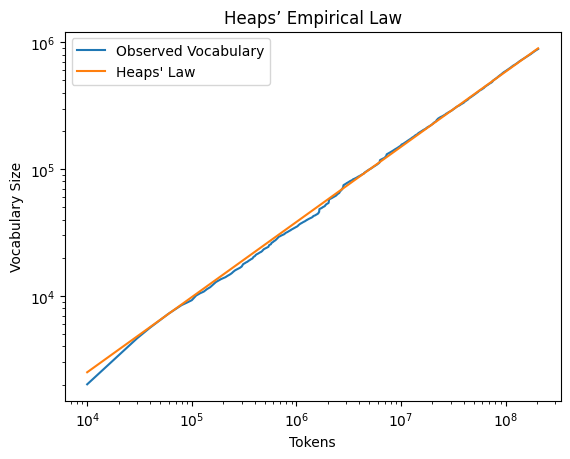

In [24]:

# Calculate vocabulary size for every 10000 tokens
vocabulary_sizes = []
tokens_range = range(10000, total_tokens + 1, 10000)
current_tokens = 0
current_vocabulary = set()

for document in tokenized_corpus:
  for token in document:
    current_tokens += 1
    current_vocabulary.add(token)
    if current_tokens in tokens_range:
      vocabulary_sizes.append(len(current_vocabulary))

# Heaps' Law: V = K * T^b
# Take the logarithm of both sides: log(V) = log(K) + b * log(T)

log_vocabulary_sizes = np.log(vocabulary_sizes)
log_tokens_range = np.log(tokens_range)

# Fit a linear model to estimate K and b
b, log_k = np.polyfit(log_tokens_range, log_vocabulary_sizes, 1)
k = np.exp(log_k)

print(f"Estimated value of K: {k}")
print(f"Estimated value of b: {b}")

# Plot the results
plt.plot(tokens_range, vocabulary_sizes, label="Observed Vocabulary")
plt.plot(tokens_range, k * np.array(tokens_range) ** b, label="Heaps' Law")
plt.xlabel("Tokens")
plt.ylabel("Vocabulary Size")
plt.title("Heaps’ Empirical Law")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


### Saving the corpus as text file

In [25]:
# untokenizing the tokenized processed corpus
untokenized_corpus = [' '.join(tokens) for tokens in tokenized_corpus]

In [26]:
# Saving the corpus as a text file
with open('corpus.txt', 'w') as f:
  for doc in untokenized_corpus:
    f.write(doc + '\n')